# AR(1) + GARCH(1,1) Model

This notebook estimates an AR(1) where the residuals follow a GARCH(1,1) model. The results are used to calculate a time-varying (daily) value at risk. 

For learning purposes the code specifies the likelihood function, calls on a optimization function and calculates (numerical) derivatives. For a more automated approach, consider the [ARCHModels.jl](https://github.com/s-broda/ARCHModels.jl) package. You may want to look at the MLE notebook before the current one.

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics, LinearAlgebra, Optim

using FiniteDiff: finite_difference_hessian as hessian, finite_difference_jacobian as jacobian

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))           #pyplot() or gr()
gr(size=(480,320))
default(fmt = :png)

## Loading Data

In [3]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2]                 #returns for the smallest size portfolio
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(y)) R[1:end-1]]         #regressors, [1, y(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$
y_{t}             =x_{t}^{\prime}b+u_{t} \: \text{ with }\: u_{t}=v_{t}\sigma_{t} \: \text{ and }
$

$
\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.
$

Notice that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is

$
\ln L=-\frac{T}{2}\ln(2\pi)  
-\frac{1}{2}\sum_{t=1}^{T}\ln\sigma_{t}^{2}-
\frac{1}{2}\sum_{t=1}^{T}\frac{u_{t}^{2}}{\sigma_{t}
^{2}}.
$

The likelihood function of a GARCH(1,1) model is in `garch11LL`.

### A Remark on the Code

For simplicity, the $\sigma_t^2$ is calculated in a loop. As an alternative, consider the `filt()` function from the [DSP.jl](https://github.com/JuliaDSP/DSP.jl) package.

In [4]:
function garch11LL(par,y,x)

    (T,k) = (size(x,1),size(x,2))

    b       = par[1:k]             #mean equation, y = x'*b
    (ω,α,β) = par[k+1:k+3]         #GARCH(1,1) equation: 
                                   #σ²(t) = ω + α*u(t-1)^2 + β*σ²(t-1)
    yhat = x*b                                
    u    = y - yhat                #fitted regression residuals
    σ²_0 = var(u)

    σ²    = zeros(typeof(α),T)     #works with ForwardDiff too
    σ²[1] = ω + α*σ²_0 + β*σ²_0
    for t = 2:T                                    
      σ²[t] = ω + α*u[t-1]^2 + β*σ²[t-1]
    end

    LL_t    = -(1/2)*log(2*π) .- (1/2)*log.(σ²) .- (1/2)*(u.^2)./σ²
    LL_t[1] = 0.0               #effectively skip the first observation

    LL      = sum(LL_t)

    return LL, LL_t, σ², yhat, u

end

garch11LL (generic function with 1 method)

## Try the Likelihood Function

In [5]:
par0 = [mean(y),0,var(y)*0.05,0.05,0.90]         #initial parameter guess

(LL,) = garch11LL(par0,y,x)                      #testing the log lik

printlnPs("Value of log-likelihood fn at starting guess of the parameters: ",LL)

Value of log-likelihood fn at starting guess of the parameters:  -9231.913


## Maximize the Likelihood Function

In [6]:
lower = [-Inf,-0.9999,0,0,0]        #upper and lower bounds on the parameters: b0,b1,ω,α,beta
upper = [Inf,0.9999,Inf,1,1]

Sol = optimize(par->-garch11LL(par,y,x)[1],lower,upper,par0)   #minimize -LL

parHat = Optim.minimizer(Sol)          #extract the optimal solution

printblue("Parameter estimates:\n")
coefNames = ["b₀","b₁","ω","α","β"]
printmat(parHat,colNames=["coef"],rowNames=coefNames)

Parameter estimates:

        coef
b₀     0.049
b₁     0.256
ω      0.014
α      0.162
β      0.824



## Standard Errors of the Estimates

MLE is typically asymptotically normally distributed

$
\sqrt{T}(\hat{\theta}-\theta)  \rightarrow^{d}N(0,V) \: \text{, where } \: V=I(\theta)^{-1}\text{ with }
$

$
I(\theta) =-\text{E}\frac{\partial^{2}\ln L_t}{\partial\theta\partial\theta^{\prime}}
$

where $\ln L_t$  is the contribution of period $t$ to the likelihood function and $I(\theta)$ is the information matrix.

The code below calculates numerical derivatives.  


Alternatively, we can use the outer product of the gradients to calculate the
information matrix as

$
J(\theta)=\text{E}\left[  \frac{\partial\ln L_t}{\partial\theta
}\frac{\partial\ln L_t}{\partial\theta^{\prime}}\right]
$

We could also use the "sandwich" estimator

$
V=I(\theta)^{-1}J(\theta)I(\theta)^{-1}.
$

### Std from Hessian

In [7]:
T = size(y,1)                    #finding std(coefs) by inverse of information matrix

Ia         = -hessian(par->mean(garch11LL(par,y,x)[2]),parHat)
Ia         = (Ia+Ia')/2              #to guarantee symmetry
vcv        = inv(Ia)/T
std_parHat = sqrt.(diag(vcv))

printblue("std from Hessian:\n")
printmat(std_parHat,colNames=["Std"],rowNames=coefNames)

std from Hessian:

         Std
b₀     0.006
b₁     0.012
ω      0.001
α      0.009
β      0.009



### Std from Gradient and Sandwich

In [8]:
LLgrad      = jacobian(par->garch11LL(par,y,x)[2],parHat)   #T x length(par) matrix, T gradients
J           = LLgrad'LLgrad/T
vcv         = inv(J)/T
stdb_parHat = sqrt.(diag(vcv))                          #std from gradients

vcv         = inv(Ia) * J * inv(Ia)/T
stdc_parHat = sqrt.(diag(vcv))                          #std from sandwich

printblue("GARCH parameter estimates and 3 different standard errors:\n")
xx = [parHat std_parHat stdb_parHat stdc_parHat]
printmat(xx,colNames=["coef","Std hessian","Std gradient","Std sandwich"],rowNames=coefNames,width=14)

GARCH parameter estimates and 3 different standard errors:

            coef   Std hessian  Std gradient  Std sandwich
b₀         0.049         0.006         0.006         0.007
b₁         0.256         0.012         0.012         0.013
ω          0.014         0.001         0.001         0.003
α          0.162         0.009         0.005         0.020
β          0.824         0.009         0.005         0.019



# Value at Risk

calculated by assuming conditional (time-varying) normality,

$
\text{VaR} = -(\mu_t - 1.645 \sigma_t),
$

where 
$\mu_t$ are the predictions from the estimated mean equation ($x_t'b$) and $\sigma_t$ from the GARCH(1,1) model.

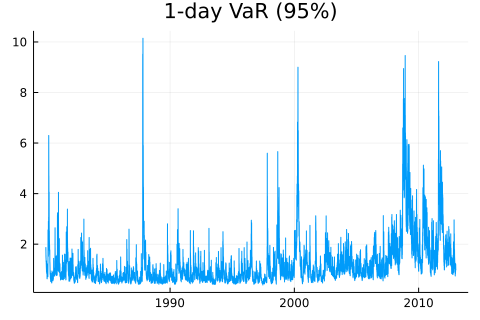

In [9]:
(σ²,μ) = garch11LL(parHat,y,x)[3:4]         #get the fitted values of the σ²- and μ-vectors
VaR95  = -(μ - 1.645*sqrt.(σ²))


xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],VaR95,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "1-day VaR (95%)" )
display(p1)

In [10]:
CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("Coverage ratio for VaR(95%): ",CovRatio)

Coverage ratio for VaR(95%):      0.058


# eGARCH (extra)

This section estimates eGARCH models for 2 return series.

In [11]:
include("jlFiles/Garch.jl")

DccParTrans (generic function with 1 method)

## Load Data

In [12]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2:end]             #returns for 10 different portfolios
xx  = nothing

R9 = R[2:end,9]                         #returns, 2nd largest firms
x9 = [ones(size(R9)) R[1:end-1,9]]      #regressors, [1, R1(t-1)]

R10 = R[2:end,10]                         #returns, largest firms
x10 = [ones(size(R10)) R[1:end-1,10]]     #regressors, [1, R10(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

## Estimate eGARCH(1,1) models

for each of the two return series. Also, calculate the standardized residuals as 
$v_t = u_t/\sigma_t$

In [13]:
par0 = [mean(R9),0,var(R9)*0.05,0.05,0.90,0]   #initial parameter guess: b0,b1,ω,α,β,γ
lower = [-Inf,-0.9999,0,0,0,-Inf]              #upper and lower bounds on the parameters
upper = [Inf,0.9999,Inf,1,1,Inf]

Sol = optimize(par->-egarch11LL(par,R9,x9)[1],lower,upper,par0)
parHat = Optim.minimizer(Sol)

(_,_,σ²_9,_,u) = egarch11LL(parHat,R9,x9)
v9 = u./sqrt.(σ²_9)                       #standardized residuals (used below)

printblue("eGARCH(1,1), parameter estimates for R9:\n")
coefNames = ["b₀","b₁","ω","α","β","γ"]
printmat(parHat,colNames=["coef"],rowNames=coefNames)

eGARCH(1,1), parameter estimates for R9:

        coef
b₀    -0.109
b₁     0.156
ω      0.000
α      0.021
β      0.981
γ     -0.102



In [14]:
Sol = optimize(par->-egarch11LL(par,R10,x10)[1],lower,upper,par0)
parHat = Optim.minimizer(Sol)

(_,_,σ²_10,_,u) = egarch11LL(parHat,R10,x10)
v10 = u./sqrt.(σ²_10)

printblue("eGARCH(1,1), parameter estimates for R10:\n")
printmat(parHat,colNames=["coef"],rowNames=coefNames)

eGARCH(1,1), parameter estimates for R10:

        coef
b₀    -0.126
b₁     0.073
ω      0.000
α      0.033
β      0.970
γ     -0.132



# DCC (extra)

This section estimates a DCC model from the two series of standardized residuals (from the eGARCH estimation above).

To impose the necessary restrictions, we estimate `(a,b)` but they imply the following `(α,β)` via the `DccParTrans()` function:

$
\alpha = \exp(a)/[1+\exp(a)+\exp(b)]
$

$
\beta = \exp(b)/[1+\exp(a)+\exp(b)]
$

In [15]:
par0 = [0.2,1.5]
(α,β) = DccParTrans(par0)            #we estimate (a,b), but they imply (α,β)

println("Initial guess of parameters")
printmat([α,β],colNames=["coef"],rowNames=["α","β"])

v   = [v9 v10]
σ²  = [σ²_9 σ²_10] 
Qbar = cov(v)

LL, = DccLL(par0,v,σ²,Qbar)       #testing the log likelihood fn
println("Testing the log likelihood fn: ",LL)

Initial guess of parameters
       coef
α     0.182
β     0.669

Testing the log likelihood fn: -15327.318829409494


In [16]:
Sol = optimize(par->-DccLL(par,v,σ²,Qbar)[1],par0)    #estimate (a,b)
parHat = Optim.minimizer(Sol)
(α,β) = DccParTrans(parHat)                           #(a,b) -> (α,β) 

println("Estimated parameters")
printmat([α,β],colNames=["coef"],rowNames=["α","β"])

Estimated parameters
       coef
α     0.008
β     0.987



In [17]:
"""
    CovToCor(covMat)

Compute correlation matrix from covariance matrix.

"""
function CovToCor(covMat)
  d      = diag(covMat)            #variances
  corMat = covMat./sqrt.(d*d')
  return corMat
end

CovToCor

In [18]:
Σ = DccLL(parHat,v,σ²,Qbar)[3]               #nxnxT covariance arrays

ρ = fill(NaN,T)                              #the fitted correlations
for t = 1:T
    ρ[t] = CovToCor(Σ[:,:,t])[1,2]
end

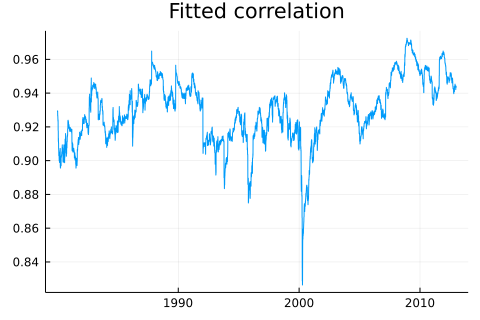

In [19]:
p1 = plot( dN[2:end],ρ,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "Fitted correlation" )
display(p1)